# Energy spectrum of sea-level or water pressure art Ciutadella

In this notebook we will show how to read a variable (time series) from a [NetCDF file](http://www.unidata.ucar.edu/software/netcdf/) and apply a filter on it.

In [1]:
%matplotlib inline

Load python modules for the filtering and plotting.

In [98]:
import numpy as np
import os
import netCDF4 as netcdf
import matplotlib.pyplot as plt
import datetime, time, calendar
import matplotlib.text as text
import matplotlib as mpl
from matplotlib import dates

## Configuration

### Period of interest

Right now for facility, working within a unique month. Later could be extended to longer periods.

In [99]:
year = 2015
month = 4
dayinit = 1
dayend = 10

Making the text bigger and the default color for lines black.

In [100]:
mpl.rcParams.update({'font.size': 20})
figdir = '/home/ctroupin/Projects/1-Internal/201530627_Rissaga/figures/Spectrum'

Setting the format for the dates (day and month)

In [101]:
hfmt = dates.DateFormatter('%d %B')

## Data access

We will use [OPeNDAP](http://www.opendap.org/) protocol do extract the data from the netCDF file

In [102]:
datafile = ("http://thredds.socib.es/thredds/dodsC/mooring/current_profiler/station_ciutadella-ime_awac001/L1/" + 
            str(year) + '/dep0001_station-ciutadella_ime-awac001_L1_' + 
            str(year) + '-' + str(month).zfill(2) + '.nc')

Now we select the dates of interest.

In [103]:
timeinit,timeend = datetime.datetime(year, month, dayinit, 0, 0),datetime.datetime(year, month, dayend, 23, 59)
tmin,tmax = time.mktime(timeinit.timetuple()), time.mktime(timeend.timetuple())

Then we load the variables time and pressure from the netCDF file, only for the period of interest.

Using "with ... as ..." to open a file, process its contents, and make sure to close it.

In [104]:
with netcdf.Dataset(datafile,'r+', format='NETCDF4') as nc:
    pressure_time = nc.variables['time'][:]
    goodtime = np.where(np.logical_and((pressure_time<=tmax), (pressure_time>=tmin)))[0]
    pressure = nc.variables['WTR_PRE'][goodtime]
    pressure_time = pressure_time[goodtime]

In [105]:
len(pressure_time)

14280

## Plotting

First we change the date format

In [106]:
dts = map(datetime.datetime.fromtimestamp, pressure_time) 
fds = dates.date2num(dts)

Now we can make a very simple plot to show the evolution of the pressure at 6 m depth.

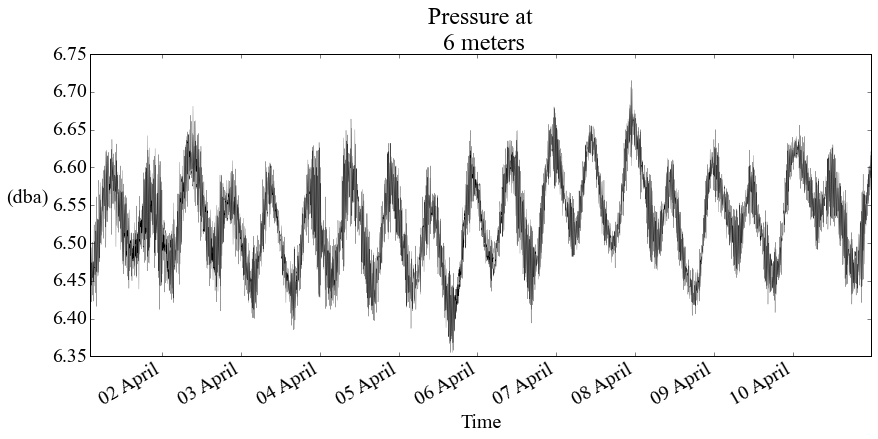

In [108]:
# Make a plot
fig = plt.figure(num=None, figsize=(14, 6))
ax = fig.add_subplot(111) 
plt.plot(fds,pressure, 'k', lw=0.2)
plt.xlabel('Time')
plt.ylabel('(dba)', ha='right', rotation=0)
plt.title('Pressure at \n 6 meters', fontsize=24)
ax.set_xlim(fds[0], fds[-1])
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(hfmt)
fig.autofmt_xdate()
figname = ('pressure_%s%s%s_%s' %(str(year), str(month).zfill(2), str(dayinit).zfill(2), str(dayend).zfill(2)))
plt.savefig(os.path.join(figdir, figname), dpi=300)

# Energy spectrum

Now we want to apply a low-pass filter on the signal. For this, we will use the signal module available in scipy.

In [109]:
from scipy import signal

In [110]:
Ts = 60.     # sampling interval
Fs = 1./Ts;  # sampling rate
print("Sampling rate = %s Hertz" %(Fs))

Sampling rate = 0.0166666666667 Hertz


## Compute energy spectrum

In [111]:
frq, Pxx_den = signal.periodogram(pressure, Fs, 'flattop', scaling='spectrum')

## Low and high frequencies

We separate frequencies above and below 0.001 Hz (arbitrary).

In [113]:
indexlow = np.where((frq<=0.001) & (frq>=2e-5))[0]
indexhigh = np.where(frq>0.001)[0]
frq_low = frq[indexlow]
frq_high = frq[indexhigh]
Pxx_den_low = Pxx_den[indexlow]
Pxx_den_high = Pxx_den[indexhigh]
nmaxlow = np.argmax(Pxx_den_low)
nmaxhigh = np.argmax(Pxx_den_high)

The main peak comes at low frequency 

In [114]:
peaklow = str(np.around(1/(frq_low[nmaxlow])/3600., decimals=2))
print("Period of main peak in hours: %s" %(peaklow))

Period of main peak in hours: 12.53


If we consider higher frequencies, i.e. larger than 0.001 Hz, we find another peak at  

In [116]:
peakhigh = str(np.around(1/(frq_high[nmaxhigh])/60., decimals=2))
print("Period of main peak in minutes: %s" %(peakhigh))

Period of main peak in minutes: 10.36


which is close to the natural oscillation mode of the Ciutadella harbour.

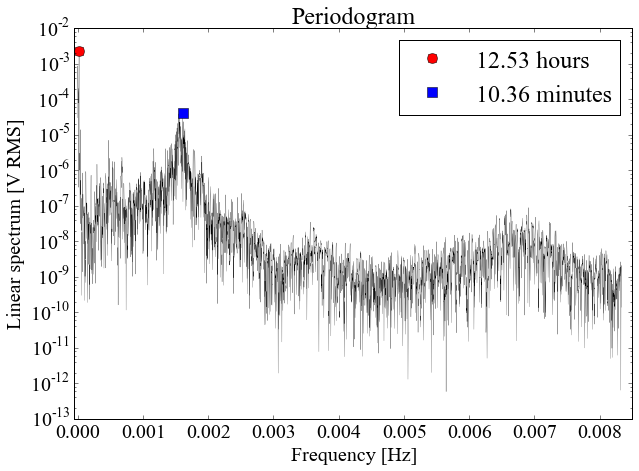

In [122]:
mpl.rcParams.update({'font.size': 20})
plt.figure(figsize=(10, 7))
plt.semilogy(frq, Pxx_den, linewidth=0.2)
plt.semilogy(frq_low[nmaxlow], Pxx_den_low[nmaxlow], 'ro', ms=10, label= peaklow + ' hours')
plt.semilogy(frq_high[nmaxhigh], Pxx_den_high[nmaxhigh], 'bs', ms=10, label= peakhigh + ' minutes')
plt.legend(loc='upper right', numpoints=1)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.xlim(-0.00005, 0.0085)
plt.title('Periodogram')
figname = ('pressure_spectrum_%s%s%s_%s' %(str(year), str(month).zfill(2), str(dayinit).zfill(2), str(dayend).zfill(2)))
plt.savefig(os.path.join(figdir, figname), dpi=300)
plt.close()